## Population density data for 2020
************************************************************
### Date: 4th Dec 2024
### Authored by: Priyanka N
************************************************************
1. This notebook first clips the image for population density for Uttarakhand from the image for India.
2. The TIF file has been downloaded from https://hub.worldpop.org/geodata/summary?id=41746 for India for the year 2020.
3. Viewing the tif file for Uttarakhand.


In [1]:
!pip install rasterio --q

In [2]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import os

In [4]:
# Paths to the input files
raster_path = "/content/drive/MyDrive/Colab Notebooks/Forest_fire_prediction/ind_pd_2020_1km.tif"
shapefile_path = "/content/drive/MyDrive/Colab Notebooks/Forest_fire_prediction/Uttarakhand/uttarakhand_WGS1984.shp"
output_path = "/content/drive/MyDrive/Colab Notebooks/Forest_fire_prediction/uttarakhand_pd_2020.tif"

In [5]:
# Load the shapefile
shapefile = gpd.read_file(shapefile_path)

In [6]:
# Ensure the shapefile's CRS matches the raster's CRS
with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    if shapefile.crs != raster_crs:
        shapefile = shapefile.to_crs(raster_crs)

# Extract the geometry of the state (shapefile)
geometries = shapefile.geometry

In [7]:
geometries

,geometry
0,"POLYGON ((79.25028 31.25536, 79.25115 31.24991..."


In [8]:
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# Crop the raster using the shapefile geometry
with rasterio.open(raster_path) as src:
    print("The CRS of the file is:", src.crs)
    # Mask the raster with the geometry
    out_image, out_transform = mask(src, geometries, crop=True)

    # Update the metadata
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save the cropped raster to a new file
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)

print(f"Cropped raster saved to {output_path}")


The CRS of the file is: EPSG:4326
Cropped raster saved to /content/drive/MyDrive/Colab Notebooks/Forest_fire_prediction/uttarakhand_pd_2020.tif


Raster Metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 418, 'height': 330, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0083333333, 0.0, 77.56541636397596,
       0.0, -0.0083333333, 31.466250067128165)}


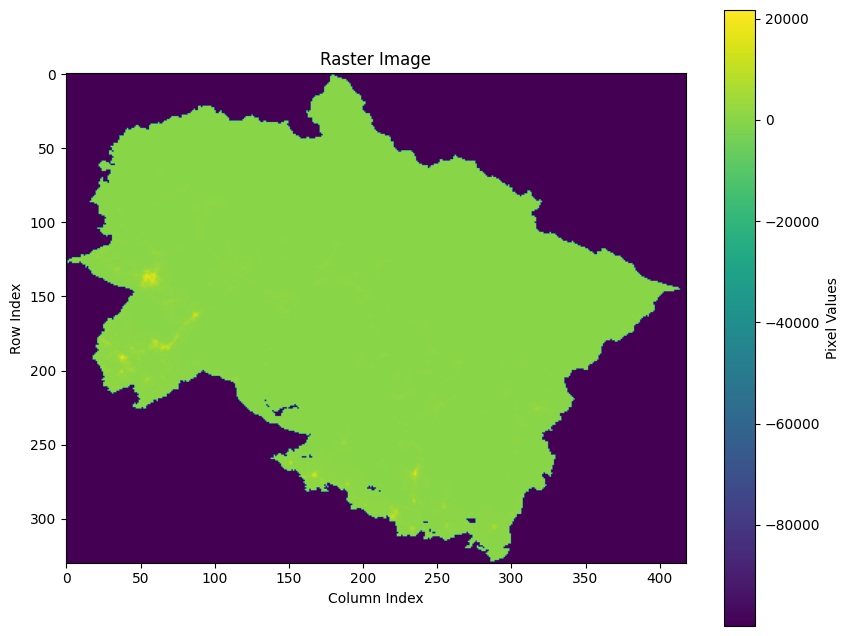

In [3]:
import matplotlib.pyplot as plt

# Path to the .tif file
tif_file_path = "/content/drive/MyDrive/Colab Notebooks/Forest_fire_prediction/uttarakhand_pd_2020.tif"

# Read the .tif file
with rasterio.open(tif_file_path) as src:
    # Read the first band of the raster
    data = src.read(1)  # Change to src.read(n) for nth band
    # Get metadata for reference
    metadata = src.meta

# Display metadata (optional)
print("Raster Metadata:")
print(metadata)

# Plot the raster
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='viridis')  # Choose a suitable colormap like 'viridis', 'gray', etc.
plt.colorbar(label='Pixel Values')
plt.title("Raster Image")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()


In [4]:
import pandas as pd
# Read the .tif file
with rasterio.open(tif_file_path) as src:
    # Read the first band
    data = src.read(1)  # Assuming single-band raster
    # Get the transform to calculate geographic coordinates
    transform = src.transform

# Convert raster values to a table
rows, cols = data.shape
values = []

for row in range(rows):
    for col in range(cols):
        # Get the raster value
        value = data[row, col]
        # Get the geographic coordinates (if needed)
        x, y = rasterio.transform.xy(transform, row, col, offset='center')
        # Append as a record
        values.append((row, col, x, y, value))

# Create a Pandas DataFrame
df = pd.DataFrame(values, columns=["Row", "Col", "Longitude", "Latitude", "Value"])

# Display the DataFrame
print(df.head())  # Show the first few rows

   Row  Col  Longitude   Latitude    Value
0    0    0  77.569583  31.462083 -99999.0
1    0    1  77.577916  31.462083 -99999.0
2    0    2  77.586250  31.462083 -99999.0
3    0    3  77.594583  31.462083 -99999.0
4    0    4  77.602916  31.462083 -99999.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137940 entries, 0 to 137939
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Row        137940 non-null  int64  
 1   Col        137940 non-null  int64  
 2   Longitude  137940 non-null  float64
 3   Latitude   137940 non-null  float64
 4   Value      137940 non-null  float32
dtypes: float32(1), float64(2), int64(2)
memory usage: 4.7 MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Row,137940.0,164.500000,95.262702,0.000000,82.00000,164.500000,247.000000,329.000000
Col,137940.0,208.500000,120.666298,0.000000,104.00000,208.500000,313.000000,417.000000
Longitude,137940.0,79.307083,1.005552,77.569583,78.43625,79.307083,80.177916,81.044583
Latitude,137940.0,30.091250,0.793856,28.720417,29.40375,30.091250,30.778750,31.462083
Value,137940.0,-47932.484375,50094.835938,-99999.000000,-99999.00000,1.308423,97.088512,21713.554688
